In [1]:
!pip install cvzone
!pip install mediapipe
!pip install tensorflow

  Preparing metadata (setup.py) ... done
  Created wheel for cvzone: filename=cvzone-1.6.1-py3-none-any.whl size=26298 sha256=1b483dac34763e8cd3a76e1ea17ccbceca545b255436ff6a10b5eda31aa73327
  Stored in directory: /root/.cache/pip/wheels/2c/9f/b3/92e945ac4a71bf727a92463f38155cc5a4fa49c5010b38ec4c
Successfully built cvzone
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 50.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
#imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report


In [4]:
# Check if GPU is being used
if tf.test.gpu_device_name():
    print(f"TensorFlow is using GPU: {tf.test.gpu_device_name()}")
else:
    print("TensorFlow is not using the GPU.")

TensorFlow is using GPU: /device:GPU:0


In [5]:
#paths
michael_data_folder = "/content/drive/MyDrive/50.035 Computer Vision Group Assignment/Data (Combined)/cropped (Mitchel & Ad)/"
landmarks_only_folder = "/content/drive/MyDrive/50.035 Computer Vision Group Assignment/Data (Combined)/cropped (Mitchel & Ad)/Landmarks (black)"
images_only_folder = "/content/drive/MyDrive/50.035 Computer Vision Group Assignment/Data (Combined)/cropped (Mitchel & Ad)/Without Landmarks"


data_folder = images_only_folder #note to nada: this path currently points at landmarks only, feel free to change if you want to train on diff dataset

In [43]:
#create csv - note: u only need to run this once btw if u keep retraining the model
import os
import pandas as pd

# Create CSV - Note: Run only once if keeping the same data
csv_path = os.path.join(michael_data_folder, '_imageonly+landmarkonly_metadata.csv')  # Note to Nada: Change this

data = []

# Iterate through image files in the main data folder
for filename in os.listdir(data_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        label = filename.split(" (")[0]
        img_only_path = os.path.join(data_folder, filename)
        landmark_only_path = os.path.join(landmarks_only_folder, filename)

        # Check if both image and landmark files exist
        if os.path.exists(img_only_path) and os.path.exists(landmark_only_path):
            data.append({"img_only_path": img_only_path, "landmark_only_path": landmark_only_path, "label": label})
        else:
            print(f"Missing file(s): {img_only_path if not os.path.exists(img_only_path) else ''}, "
                  f"{landmark_only_path if not os.path.exists(landmark_only_path) else ''}")

# Create DataFrame from the valid data
df = pd.DataFrame(data)
print(df.head())

# Map unique labels to numeric values
unique_labels = df['label'].unique()
label_map = {label: idx for idx, label in enumerate(unique_labels)}
df['numeric_label'] = df['label'].map(label_map)
df = df.drop(columns='label')

df.to_csv(csv_path, index=False)
print("CSV created and saved successfully!")
print(df.head())

Missing file(s): , /content/drive/MyDrive/50.035 Computer Vision Group Assignment/Data (Combined)/cropped (Mitchel & Ad)/Landmarks (black)/bis_F (24) (1).jpg
Missing file(s): , /content/drive/MyDrive/50.035 Computer Vision Group Assignment/Data (Combined)/cropped (Mitchel & Ad)/Landmarks (black)/bis_G (24) (1).jpg
Missing file(s): , /content/drive/MyDrive/50.035 Computer Vision Group Assignment/Data (Combined)/cropped (Mitchel & Ad)/Landmarks (black)/bis_I (5) (1).jpg
Missing file(s): , /content/drive/MyDrive/50.035 Computer Vision Group Assignment/Data (Combined)/cropped (Mitchel & Ad)/Landmarks (black)/bis_N (37) (1).jpg
Missing file(s): , /content/drive/MyDrive/50.035 Computer Vision Group Assignment/Data (Combined)/cropped (Mitchel & Ad)/Landmarks (black)/bis_Q (20) (1).jpg
Missing file(s): , /content/drive/MyDrive/50.035 Computer Vision Group Assignment/Data (Combined)/cropped (Mitchel & Ad)/Landmarks (black)/bis_R (29) (1).jpg
Missing file(s): , /content/drive/MyDrive/50.035 Comp

In [44]:
print(label_map)

{'bis_N': 0, 'bis_O': 1, 'bis_P': 2, 'bis_Q': 3, 'bis_A': 4, 'bis_B': 5, 'bis_R': 6, 'bis_C': 7, 'bis_D': 8, 'bis_E': 9, 'bis_F': 10, 'bis_G': 11, 'bis_S': 12, 'bis_T': 13, 'bis_U': 14, 'bis_V': 15, 'bis_W': 16, 'bis_Y': 17, 'bis_Z': 18, 'bis_H': 19, 'bis_I': 20, 'bis_X': 21, 'bis_K': 22, 'bis_L': 23, 'bis_M': 24, 'tur_S': 25, 'tur_T': 26, 'tur_U': 27, 'tur_V': 28, 'tur_Y': 29, 'tur_Z': 30, 'tur_H': 31, 'tur_I': 32, 'tur_J': 33, 'tur_K': 34, 'tur_L': 35, 'tur_M': 36, 'tur_N': 37, 'tur_O': 38, 'tur_P': 39, 'tur_R': 40, 'tur_A': 41, 'tur_B': 42, 'tur_C': 43, 'tur_D': 44, 'tur_E': 45, 'tur_F': 46, 'tur_G': 47}


In [45]:
# Load the metadata CSV
metadata = pd.read_csv(csv_path)

# Ensure the 'img_path' column contains full paths to images
metadata.head()

,img_only_path,landmark_only_path,numeric_label
0,/content/drive/MyDrive/50.035 Computer Vision ...,/content/drive/MyDrive/50.035 Computer Vision ...,0
1,/content/drive/MyDrive/50.035 Computer Vision ...,/content/drive/MyDrive/50.035 Computer Vision ...,0
2,/content/drive/MyDrive/50.035 Computer Vision ...,/content/drive/MyDrive/50.035 Computer Vision ...,0
3,/content/drive/MyDrive/50.035 Computer Vision ...,/content/drive/MyDrive/50.035 Computer Vision ...,0
4,/content/drive/MyDrive/50.035 Computer Vision ...,/content/drive/MyDrive/50.035 Computer Vision ...,0


In [10]:
def split_metadata(metadata, train_frac=0.8, val_frac=0.5, random_seed=42):
    train_df = metadata.sample(frac=train_frac, random_state=random_seed)
    remaining_df = metadata.drop(train_df.index)

    val_df = remaining_df.sample(frac=val_frac, random_state=random_seed)
    test_df = remaining_df.drop(val_df.index)

    return train_df, val_df, test_df

In [46]:
train_df, val_df, test_df = split_metadata(metadata)

In [47]:
# Convert 'numeric_label' to string for compatibility with class_mode='categorical'
train_df['numeric_label'] = train_df['numeric_label'].astype(str)
val_df['numeric_label'] = val_df['numeric_label'].astype(str)
test_df['numeric_label'] = test_df['numeric_label'].astype(str)

In [48]:
# Paths and labels from the DataFrame
train_image_paths = train_df['img_only_path'].values
train_landmark_paths = train_df['landmark_only_path'].values
train_labels = tf.keras.utils.to_categorical(train_df['numeric_label'].astype(int).values)
val_image_paths = val_df['img_only_path'].values
val_landmark_paths = val_df['landmark_only_path'].values
val_labels = tf.keras.utils.to_categorical(val_df['numeric_label'].astype(int).values)
test_image_paths = test_df['img_only_path'].values
test_landmark_paths = test_df['landmark_only_path'].values
test_labels = tf.keras.utils.to_categorical(test_df['numeric_label'].astype(int).values)

# Preprocessing function for loading and resizing images
def preprocess_image(file_paths, label):
    def preprocess(file_path):
        image = tf.io.read_file(file_path)
        image = tf.image.decode_jpeg(image, channels=3)  # Adjust for JPEG; change to decode_png for PNG files
        image = tf.image.resize(image, [224, 224])  # Resize to target size
        image = image / 255.0  # Normalize pixel values to [0, 1]
        return image

    # Apply preprocessing to both image paths
    image1 = preprocess(file_paths[0])
    image2 = preprocess(file_paths[1])

    return (image1, image2), label

# Create tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices(((train_image_paths, train_landmark_paths), train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices(((val_image_paths, val_landmark_paths), val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices(((test_image_paths, test_landmark_paths), test_labels))

# Apply preprocessing
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Optimize datasets
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)


In [49]:
num_classes = 48

def build_model(input_shape, num_classes):
    """
    Build a dual-input CNN model for gesture recognition.
    """
    # Input for preprocessed images
    input_preprocessed = Input(shape=input_shape, name='Preprocessed_Input')
    x1 = Conv2D(32, (3, 3), activation='relu')(input_preprocessed)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Flatten()(x1)

    # Input for hand landmark images
    input_landmarks = Input(shape=input_shape, name='Landmark_Input')
    x2 = Conv2D(32, (3, 3), activation='relu')(input_landmarks)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Flatten()(x2)

    # Combine both CNN branches
    combined = Concatenate()([x1, x2])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    # Create model
    model = Model(inputs=[input_preprocessed, input_landmarks], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [50]:
# Build and train the model
input_shape = (224,224,3)
model = build_model(input_shape, 48)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Preprocessed_Input        │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Landmark_Input            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 222, 222, 32)   │            896 │ Preprocessed_Input[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 222, 222, 32)   │            896 │ Landmark_Input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 111, 111, 32)   │              0 │ conv2d_11[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 111, 111, 32)   │              0 │ conv2d_12[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_8 (Flatten)       │ (None, 394272)         │              0 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_9 (Flatten)       │ (None, 394272)         │              0 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 788544)         │              0 │ flatten_8[0][0],       │
│ (Concatenate)             │                        │                │ flatten_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 128)            │    100,933,760 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128)            │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 48)             │          6,192 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 100,941,744 (385.06 MB)

 Trainable params: 100,941,744 (385.06 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10, batch_size=32
)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.0545 - loss: 7.6200 - val_accuracy: 0.6562 - val_loss: 1.5677
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - accuracy: 0.5254 - loss: 1.6216 - val_accuracy: 0.9887 - val_loss: 0.0641
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - accuracy: 0.8722 - loss: 0.3949 - val_accuracy: 0.9950 - val_loss: 0.0181
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - accuracy: 0.9326 - loss: 0.2076 - val_accuracy: 0.9975 - val_loss: 0.0110
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - accuracy: 0.9564 - loss: 0.1313 - val_accuracy: 1.0000 - val_loss: 0.0065
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - accuracy: 0.9729 - loss: 0.0900 - val_accuracy: 0.9975 - val_loss: 0.0041
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - accuracy: 0.9671 - loss: 0.0979 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - accuracy: 0.9781 - loss: 0.0641 - v

In [52]:
# evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Set Accuracy: {test_accuracy}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9953 - loss: 0.0171
Test Set Accuracy: 0.9974905848503113


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step


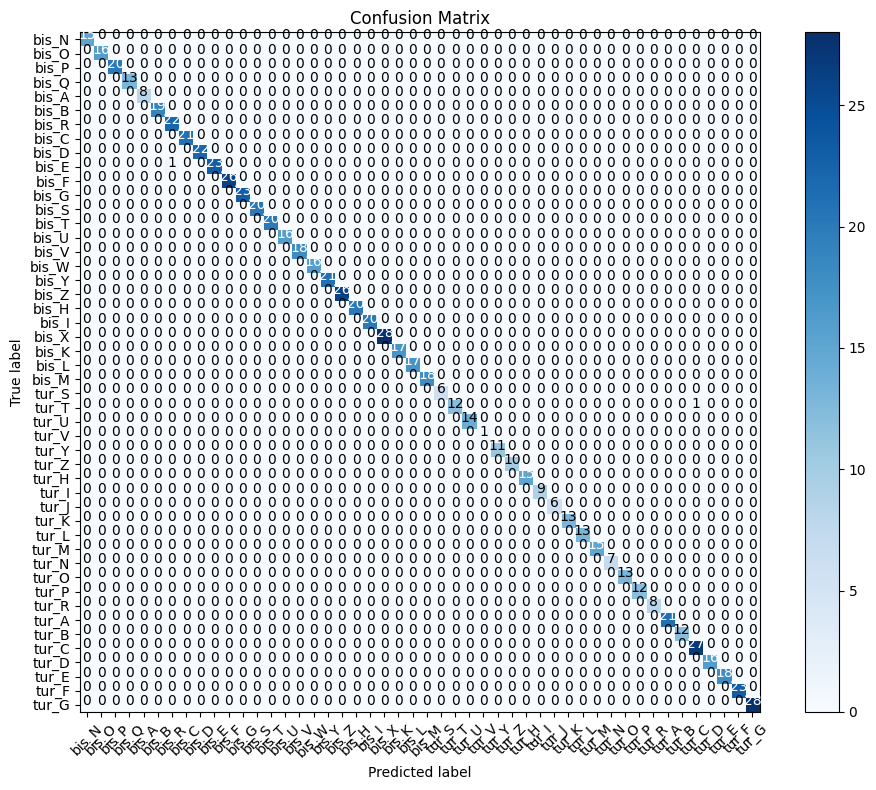

In [53]:
def get_labels(dataset):
    labels = []
    for _, label in dataset:
        labels.append(label.numpy())
    return np.concatenate(labels)

y_true = get_labels(test_dataset)

y_pred = np.argmax(model.predict(test_dataset), axis=1)

# ensure y_true is a 1D array of class labels (not one-hot encoded)
y_true = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true

cm = confusion_matrix(y_true, y_pred)
class_names = list(label_map.keys())


# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cm, class_names)
plt.show()



In [54]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

       bis_N       1.00      1.00      1.00        15
       bis_O       1.00      1.00      1.00        16
       bis_P       1.00      1.00      1.00        20
       bis_Q       1.00      1.00      1.00        13
       bis_A       1.00      1.00      1.00         8
       bis_B       1.00      1.00      1.00        19
       bis_R       0.96      1.00      0.98        22
       bis_C       1.00      1.00      1.00        21
       bis_D       1.00      1.00      1.00        22
       bis_E       1.00      0.96      0.98        24
       bis_F       1.00      1.00      1.00        26
       bis_G       1.00      1.00      1.00        23
       bis_S       1.00      1.00      1.00        20
       bis_T       1.00      1.00      1.00        20
       bis_U       1.00      1.00      1.00        16
       bis_V       1.00      1.00      1.00        18
       bis_W       1.00      1.00      1.00        16
    

In [55]:
# Compute F2 score
def fbeta_score(y_true, y_pred, beta=2):
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, _, _ = precision_recall_fscore_support(y_true, y_pred, beta=beta, average='weighted')
    fbeta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-7)
    return fbeta

f2_score = fbeta_score(y_true, y_pred, beta=2)
print(f"F2 Score: {f2_score}")

F2 Score: 0.997510440788193


In [56]:
model_path = os.path.join(michael_data_folder,'models/multiheadcnn.h5')
model.save(model_path)


In [57]:
print(label_map)

{'bis_N': 0, 'bis_O': 1, 'bis_P': 2, 'bis_Q': 3, 'bis_A': 4, 'bis_B': 5, 'bis_R': 6, 'bis_C': 7, 'bis_D': 8, 'bis_E': 9, 'bis_F': 10, 'bis_G': 11, 'bis_S': 12, 'bis_T': 13, 'bis_U': 14, 'bis_V': 15, 'bis_W': 16, 'bis_Y': 17, 'bis_Z': 18, 'bis_H': 19, 'bis_I': 20, 'bis_X': 21, 'bis_K': 22, 'bis_L': 23, 'bis_M': 24, 'tur_S': 25, 'tur_T': 26, 'tur_U': 27, 'tur_V': 28, 'tur_Y': 29, 'tur_Z': 30, 'tur_H': 31, 'tur_I': 32, 'tur_J': 33, 'tur_K': 34, 'tur_L': 35, 'tur_M': 36, 'tur_N': 37, 'tur_O': 38, 'tur_P': 39, 'tur_R': 40, 'tur_A': 41, 'tur_B': 42, 'tur_C': 43, 'tur_D': 44, 'tur_E': 45, 'tur_F': 46, 'tur_G': 47}
